In [1]:
spark

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 51, 6, Finished, Available, Finished)

In [2]:
workspace_default_storage_account = "projectgstoragedfb938a3e"
workspace_default_container = "azureml-blobstore-becc8696-e562-432e-af12-8a5e3e1f9b0f"
workspace_wasbs_base_url = f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 51, 7, Finished, Available, Finished)

In [15]:
from pyspark.sql.functions import lit
import pandas

cancer_path = f"{workspace_wasbs_base_url}cancer_subreddit_sentiment.parquet"
cancer_df = spark.read.parquet(cancer_path)

not_cancer_path = f"{workspace_wasbs_base_url}not_cancer_subreddit_sentiment.parquet"
not_cancer = spark.read.parquet(not_cancer_path)

cancer_df = cancer_df.withColumn("source", lit("cancer"))

not_cancer = not_cancer.withColumn("source", lit("non_cancer"))

df = cancer_df.union(not_cancer)
df = df.select('text', 'source')

df = df.toPandas()

df.head()

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 51, 20, Finished, Available, Finished)

,text,source
0,"Check out Northside Hospital -Atlanta, Piedmon...",cancer
1,I had something similar and managed to get it ...,cancer
2,"That's an insulting offer, and I'm a LPN. Out ...",cancer
3,"Yeah sorry, it was my mistake. I meant to say ...",cancer
4,I see my colorectal dr tomorrow. My disease is...,cancer


In [4]:
df = df[['text']]
df = df.rename(columns={'text': 'text_column'})
df.head()

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 51, 9, Finished, Available, Finished)

,text_column
0,"Check out Northside Hospital -Atlanta, Piedmon..."
1,I had something similar and managed to get it ...
2,"That's an insulting offer, and I'm a LPN. Out ..."
3,"Yeah sorry, it was my mistake. I meant to say ..."
4,I see my colorectal dr tomorrow. My disease is...


In [5]:
%pip install nrclex

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 50, 14, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 KB 32.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43311 sha256=cae5fce672ccf3c39750949dcdd10ee6675f9772ee4281a209bd8e3da5eb69b2
  Stored in directory: /home/trusted-service-user/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built nrclex
You should consider upgrading via the '/nfs4/pyenv-13cafb8c-6b93-47c4-a1e6-669a4e47a31e/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import nrclex
import nltk
from multiprocessing import Pool

# Download NLTK data for tokenization
nltk.download('punkt')

# Sample dataframe with a text column
#data = {'text_column': ["I love coding!", "I hate bugs in my code.", "This is a neutral statement.", 
#                        "I enjoy solving problems!", "I get frustrated when things don't work."]}
#df = pd.DataFrame(data)

# Define a function to get sentiment from NRC lexicon
def get_sentiment(text):
    if isinstance(text, str):
        # Initialize NRC lexicon for each text
        nrc_lex = nrclex.NRCLex(text)
        affect_frequencies = nrc_lex.affect_frequencies
        
        # Extracting positive, negative, neutral, and other emotions including 'trust'
        sentiment = {
            "positive": affect_frequencies.get("positive", 0),
            "negative": affect_frequencies.get("negative", 0),
            "neutral": affect_frequencies.get("neutral", 0),
            "anger": affect_frequencies.get("anger", 0),
            "fear": affect_frequencies.get("fear", 0),
            "disgust": affect_frequencies.get("disgust", 0),
            "sadness": affect_frequencies.get("sadness", 0),
            "joy": affect_frequencies.get("joy", 0),
            "surprise": affect_frequencies.get("surprise", 0),
            "trust": affect_frequencies.get("trust", 0)  # Added trust emotion
        }
        return sentiment
    return {
        "positive": 0, "negative": 0, "neutral": 0, "anger": 0, "fear": 0, 
        "disgust": 0, "sadness": 0, "joy": 0, "surprise": 0, "trust": 0  # Default 0 for all emotions
    }

# Function to process a chunk of data
def process_chunk(chunk):
    chunk[['positive', 'negative', 'neutral', 'anger', 'fear', 'disgust', 'sadness', 'joy', 'surprise', 'trust']] = \
        chunk['text_column'].apply(get_sentiment).apply(pd.Series)
    return chunk

# Function to split dataframe into chunks
def split_dataframe(df, num_chunks):
    chunk_size = len(df) // num_chunks
    return [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

# Number of chunks for parallel processing (adjust based on your system's cores)
num_chunks = 4  # or a value that suits your setup

# Step 1: Split the DataFrame into chunks
chunks = split_dataframe(df, num_chunks)

# Step 2: Use multiprocessing to process the chunks in parallel
with Pool(processes=num_chunks) as pool:
    result_chunks = pool.map(process_chunk, chunks)

# Step 3: Combine the processed chunks back into a single DataFrame
final_df = pd.concat(result_chunks, ignore_index=True)

# Display the final dataframe with sentiment columns
print(final_df)


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 50, 26, Finished, Available, Finished)

[nltk_data] Downloading package punkt to /home/trusted-service-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                             text_column  positive  negative  \
0      Check out Northside Hospital -Atlanta, Piedmon...  0.198020  0.089109   
1      I had something similar and managed to get it ...  0.666667  0.000000   
2      That's an insulting offer, and I'm a LPN. Out ...  0.275862  0.103448   
3      Yeah sorry, it was my mistake. I meant to say ...  0.000000  0.500000   
4      I see my colorectal dr tomorrow. My disease is...  0.000000  0.166667   
...                                                  ...       ...       ...   
19995  Switch update was just a normal firmware updat...  0.000000  0.000000   
19996                                          [removed]  0.000000  0.000000   
19997  When will someone just fucking follow glorious...  0.000000  0.166667   
19998                                  Ew, STFU already.  0.000000  0.000000   
19999  Szemely szerint csak bemutatkoznek neki udvari...  0.000000  0.000000   

       neutral     anger      fear   di

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 50, 27, Finished, Available, Finished)

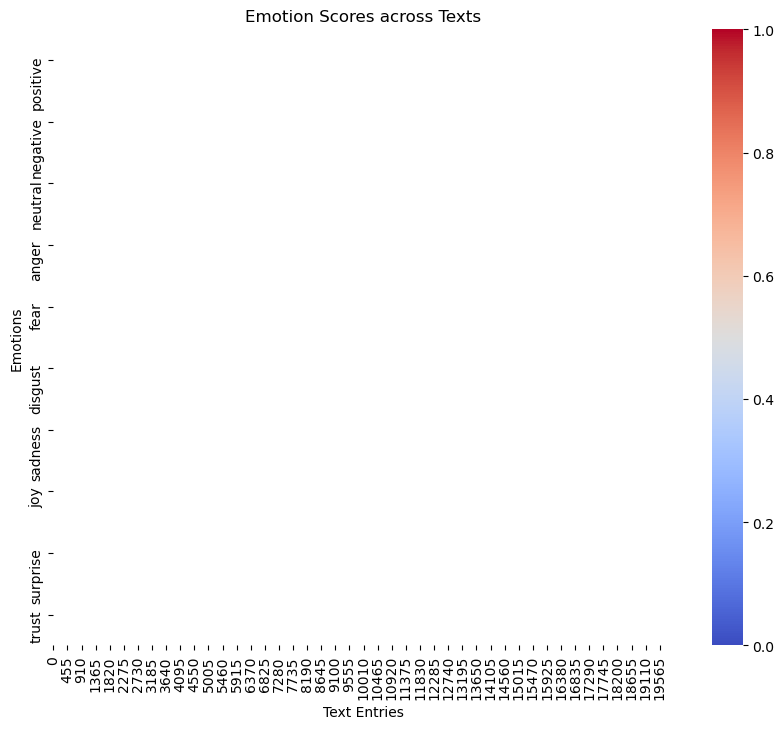

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns related to emotions (excluding 'text_column' and 'source')
emotion_columns = ['positive', 'negative', 'neutral','anger', 'fear', 'disgust', 'sadness', 'joy', 'surprise', 'trust']

# Select the rows and emotions data for plotting
emotion_data = final_df[emotion_columns]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(emotion_data.T, cmap="coolwarm", cbar=True, annot=False, linewidths=0.5)
plt.title('Emotion Scores across Texts')
plt.xlabel('Text Entries')
plt.ylabel('Emotions')
plt.show()


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 50, 28, Finished, Available, Finished)

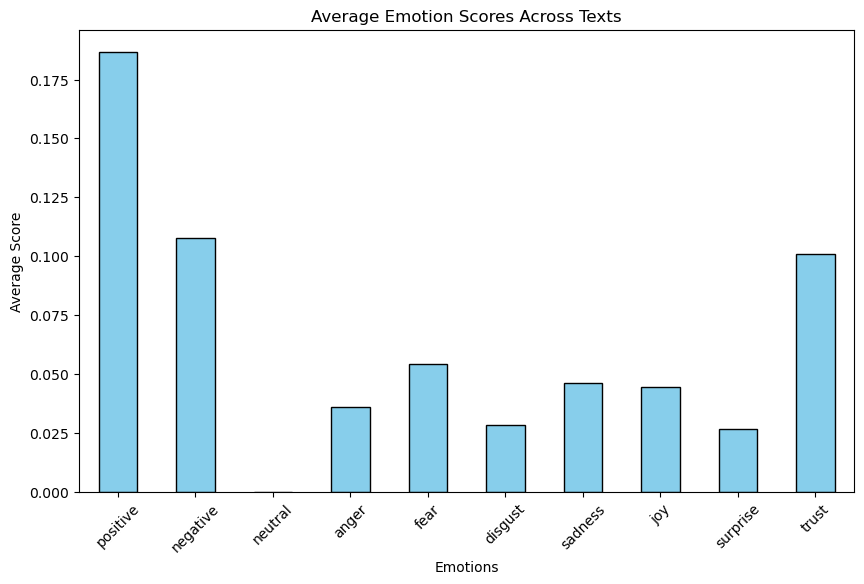

In [14]:
import matplotlib.pyplot as plt

# Calculate the mean emotion score for each emotion
mean_emotions = emotion_data.mean()

# Plot the results
plt.figure(figsize=(10, 6))
mean_emotions.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Emotion Scores Across Texts')
plt.xlabel('Emotions')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()

In [15]:
%pip install wordcloud

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 50, 32, Submitted, Running, Running)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 KB 20.2 MB/s eta 0:00:00
You should consider upgrading via the '/nfs4/pyenv-13cafb8c-6b93-47c4-a1e6-669a4e47a31e/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# positive vs negative
#positive_comments = ' '.join(df[df['sentiment_score'] > 0]['body'])
#negative_comments = ' '.join(df[df['sentiment_score'] < 0]['body'])

text = ' '.join(df['text_column'])


plt.figure(figsize=(15, 7))

# positive
plt.subplot(1, 2, 1)
wordcloud = WordCloud(background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Comments')

# negative
#plt.subplot(1, 2, 2)
#wordcloud = WordCloud(background_color='white').generate(negative_comments)
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.title('Negative Comments')

#plt.show()

StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 50, 33, Finished, Available, Finished)

NameError: name 'df' is not defined

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

cancer_df_pd = cancer_df[['text']]
cancer_df_pd = cancer_df_pd.toPandas()

custom_stop_words = ENGLISH_STOP_WORDS.union({"just", "like", "don", "https", "use", "does",
 "post", "subreddit", "know", "ve", "com", "www", "reddit", "message", "think", "good", "automatically", "0a", "askdocs"})

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, max_features=20)  # You can adjust max_features as needed

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(cancer_df_pd['text'])

# Get the feature names (words) and their corresponding TF-IDF values
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Sum of TF-IDF scores for each term

# Create a DataFrame with words and their TF-IDF scores
tfidf_df = pd.DataFrame(list(zip(feature_names, tfidf_scores)), columns=['word', 'tfidf'])
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)

# Display the top 10 important words by TF-IDF
print(tfidf_df.head(10))


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 51, 24, Finished, Available, Finished)

           word       tfidf
19         time  681.328379
18        thank  526.850892
8        doctor  507.619846
16      removed  491.338708
9   information  469.121596
12      patient  415.446383
3          best  373.206905
10         life  326.335104
15    questions  291.785379
6      concerns  235.795821


StatementMeta(ba5e360d-f184-47a0-9859-76b5031b79e3, 51, 25, Finished, Available, Finished)

/tmp/ipykernel_13514/2996807760.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.bar(tfidf_df['word'][:10], tfidf_df['tfidf'][:10], color='lightgreen')


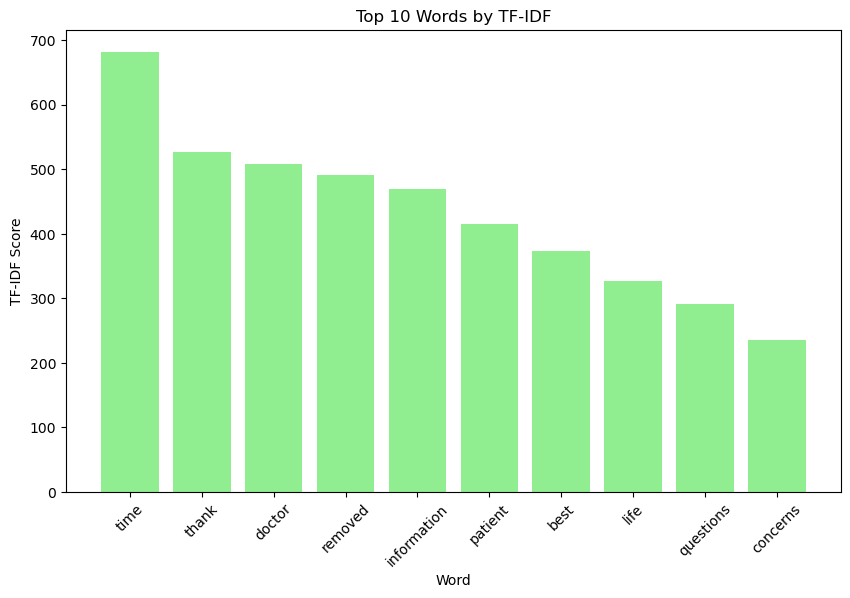

In [20]:
import matplotlib.pyplot as plt
# Plot the top 10 words by TF-IDF score
plt.figure(figsize=(10, 6))
plt.bar(tfidf_df['word'][:10], tfidf_df['tfidf'][:10], color='lightgreen')
plt.title('Top 10 Words by TF-IDF')
plt.xlabel('Word')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45)
plt.show()
